In [1]:
import torch
import pandas as pd
import numpy as np
from fastai import vision
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.vision.data import ImageDataLoaders
from fastai.vision.learner import cnn_learner
from fastai.vision.augment import aug_transforms


from fastai.vision.all import *
from pathlib import Path
import os


#### Lets see what are there in the path


In [2]:
x = r"C:\Users\Admin\Desktop\Retinal OCT Project\archive\OCT2017\OCT2017"
path = Path(x)
path.ls()

(#4) [Path('C:/Users/Admin/Desktop/Retinal OCT Project/archive/OCT2017/OCT2017/.DS_Store'),Path('C:/Users/Admin/Desktop/Retinal OCT Project/archive/OCT2017/OCT2017/test'),Path('C:/Users/Admin/Desktop/Retinal OCT Project/archive/OCT2017/OCT2017/train'),Path('C:/Users/Admin/Desktop/Retinal OCT Project/archive/OCT2017/OCT2017/val')]

##### Set up random seed and make a instance for datablock which will take care of folder and everything

In [3]:
np.random.seed(42)

In [14]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
).dataloaders(path)

In [ ]:
n_subsets = len(data.n_subsets)
print("Number of subsets:", n_subsets)

for i in range(n_subsets):
    print(f"Subset {i+1}: {data.vocab[i]}")

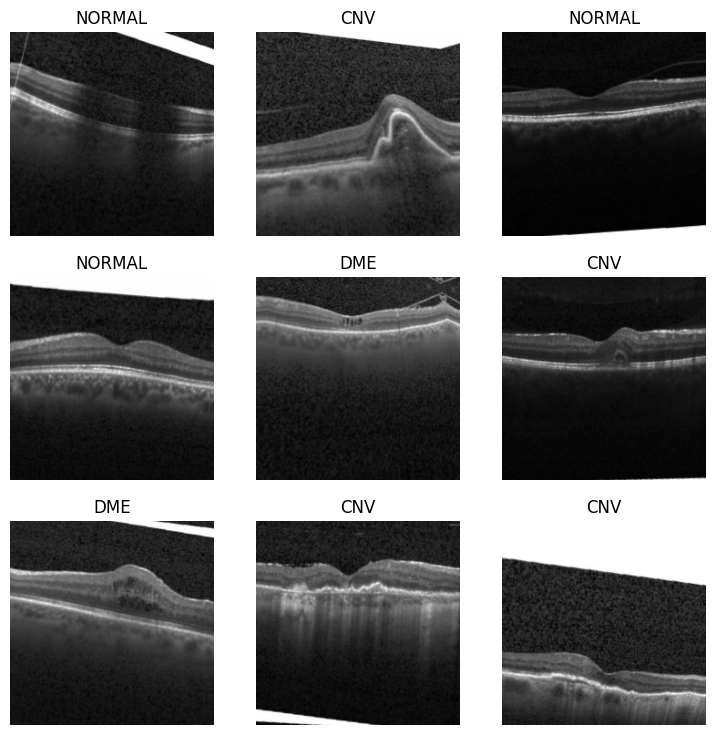

In [15]:
data.show_batch()

In [33]:
data

##### Lets see how many classes are there in the dataset

In [16]:
num_classes = data.c
print("Number of classes:", num_classes)

Number of classes: 4


In [34]:
import torch

print("CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)


CUDA version: 11.7
PyTorch version: 2.0.1+cu117


##### Lets move to the learning part

c:\Users\Admin\anaconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


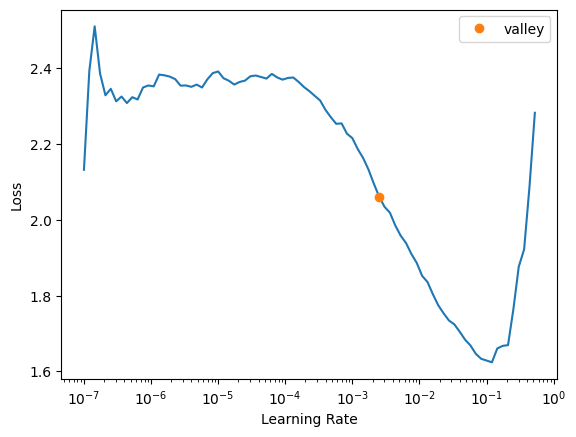

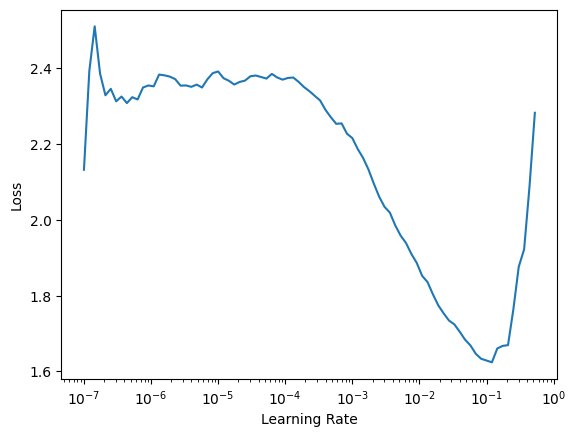

In [4]:
from fastai.vision.all import *

data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
).dataloaders(path)

learn = vision_learner(data, models.resnet18, 
                       pretrained=True, 
                       metrics=accuracy, 
                       model_dir=Path(r"C:\Users\Admin\Desktop\Retinal OCT Project\archive\OCT2017\ModelDir"), 
                       path=Path("."))

# Move the model and data to the CPU
learn = learn.to_fp32()

# Find optimal learning rate
learn.lr_find()

# Plot learning rate curve
learn.recorder.plot_lr_find()


In [15]:
print(data.dataloaders)


<bound method FilteredBase.dataloaders of (#59139) [(PILImage mode=RGB size=1536x496, TensorCategory(0)),(PILImage mode=RGB size=512x496, TensorCategory(0)),(PILImage mode=RGB size=1536x496, TensorCategory(0)),(PILImage mode=RGB size=512x496, TensorCategory(0)),(PILImage mode=RGB size=1536x496, TensorCategory(0)),(PILImage mode=RGB size=768x496, TensorCategory(3)),(PILImage mode=RGB size=768x496, TensorCategory(0)),(PILImage mode=RGB size=512x496, TensorCategory(2)),(PILImage mode=RGB size=768x496, TensorCategory(0)),(PILImage mode=RGB size=768x496, TensorCategory(3))...]>


Best learning rate suggestion: 0.001


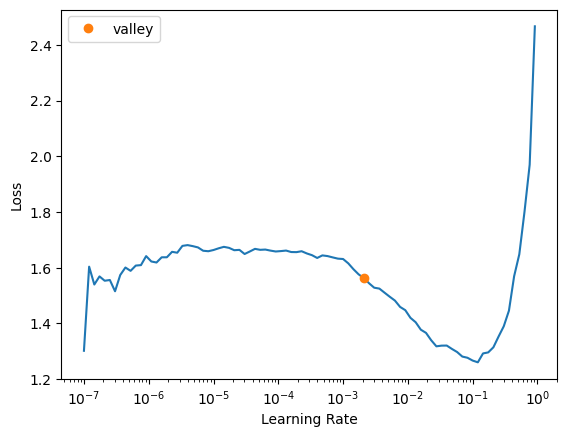

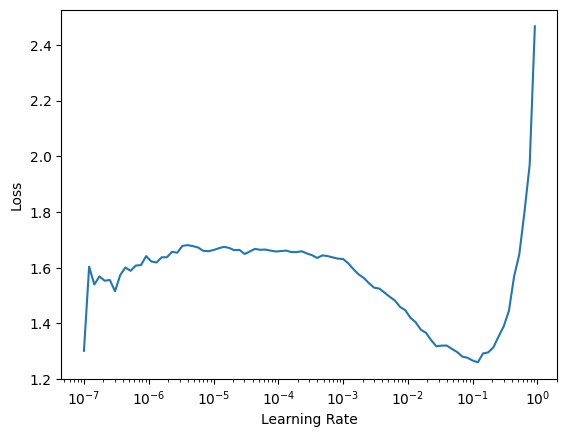

In [8]:
# Find optimal learning rate
learn.lr_find()

# Plot learning rate curve
learn.recorder.plot_lr_find()

# Manually identify the learning rate suggestion
suggested_lr = 1e-3  # Modify this value based on the plot

# Print the learning rate suggestion
print("Best learning rate suggestion:", suggested_lr)


#### train for 10 epochs


In [9]:
# Move the model and data to the GPU
learn.model = learn.model.to(torch.device("cuda"))
learn.dls = learn.dls.cuda()

# Fit the model using the suggested learning rate
learn.fit_one_cycle(10, lr_max=suggested_lr)



epoch,train_loss,valid_loss,accuracy,time


In [10]:
learn.validate()


(#2) [0.12036652117967606,0.9584928154945374]

#### Saving the model

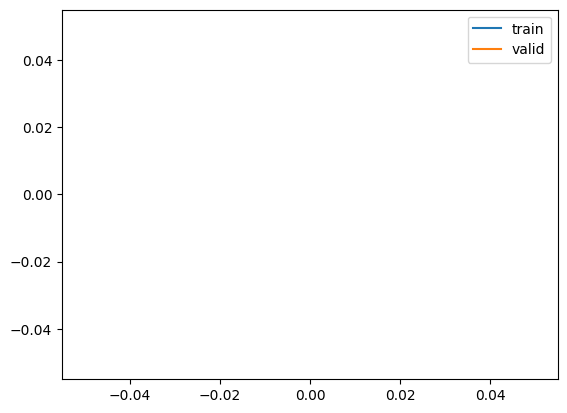

In [11]:

learn.export("model.pth")



#### Interpretaion of results using confusion matrix and classification report

              precision    recall  f1-score   support

         CNV       0.98      0.97      0.97     11196
         DME       0.97      0.93      0.95      3437
      DRUSEN       0.87      0.88      0.88      2652
      NORMAL       0.95      0.99      0.97      8060

    accuracy                           0.96     25345
   macro avg       0.94      0.94      0.94     25345
weighted avg       0.96      0.96      0.96     25345



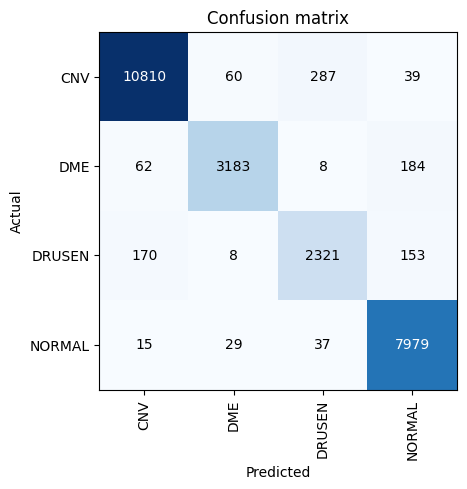

In [12]:
# Generate predictions on the validation set
interp = ClassificationInterpretation.from_learner(learn)

# Generate confusion matrix
interp.plot_confusion_matrix()

# Generate classification report
interp.print_classification_report()


##### Hpyer parameter tuning

In [18]:
from fastai.callback.progress import ShowGraphCallback


In [23]:
# Move the model and data to the GPU
learn.model = learn.model.to(torch.device("cuda"))
learn.dls = learn.dls.cuda()
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.206485,0.145283,0.950010,15:12


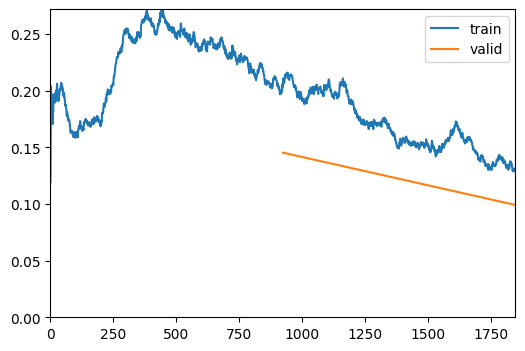

In [24]:
learn.fit_one_cycle(2, lr_max=suggested_lr, cbs=ShowGraphCallback())



##### Plotting some misclassified samples

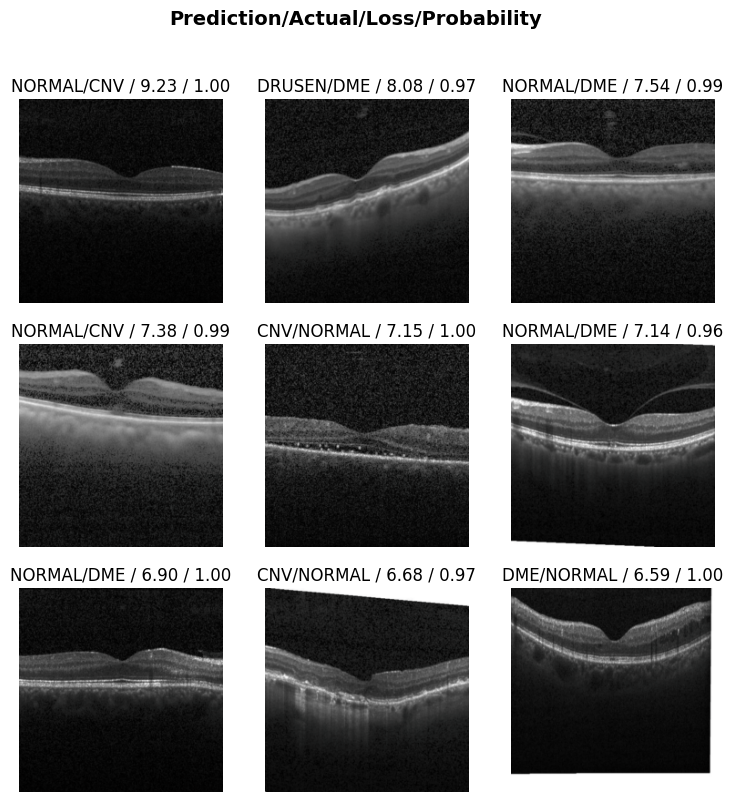

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(k=9)
